<div class='alert alert-info' style='text-align: center'><h1>Lung segmentation without a CNN</h1>
    - yet another chest x-ray processing notebook -
</div>

#### In this notebook, we'll use a combination of sklearn processing and filters to extract lung areas and bounding boxes.

The basic steps are:
- Equalize the image with CLAHE
- Create a threshold mask to separate tissue by pixel intensity
- Find regions in the threshold
- Remove borders
- Fill small holes
- Extract lung areas

The end result is a segment mask and a bounding boxes that represent the lung fields.

In [ ]:
# You will need to run this command if opening a JPG encoded DICOM file
#!conda install gdcm -c conda-forge -y

In [1]:
import os
import numpy as np
import pydicom
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage.filters import threshold_otsu
from skimage.exposure import equalize_adapthist
from skimage.color import label2rgb
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import square,closing

In [2]:
# This function gets the first image path in a StudyInstanceUID directory in the train set.
# I use this so I don't have to keep clicking down to get a test image path each time I try a new one.

def get_image_by_study_id(study_id):
    base_path = "/kaggle/input/siim-covid19-detection/"
    study_path = base_path + "train/" + study_id + "/"
    images = []
    for subdir, dirs, files in os.walk(study_path):
        for file in files:     
            image = os.path.join(subdir, file)
            if os.path.isfile(image):
                return image
    return "none"

In [3]:
# Load a DICOM file and get the pixels

def load_image(study_id):
    img_file = get_image_by_study_id(study_id)
    image = pydicom.dcmread(img_file)
    pixels = image.pixel_array

    min_pixel = np.min(pixels)
    max_pixel = np.max(pixels)

    if image.PhotometricInterpretation == "MONOCHROME1":
        pixels = max_pixel - pixels
    else:
        pixels = pixels

    return pixels

In [4]:
# This is the main function, it applies all the filters and plots the original and segmented image
# Tweak params here to fine tune

def segment(img):

    # Even out the contrast with CLAHE
    img = equalize_adapthist(img, kernel_size=None, clip_limit=0.01, nbins=256)
    
    # Make a binary threshold mask and apply it to the image 
    thresh = threshold_otsu(image=img, nbins=256, hist=None)
    thresh = img > thresh
    bw = closing(img > thresh, square(3))

    # clean up the borders
    cleared = clear_border(bw)

    # label image regions
    label_image = label(cleared)
    image_label_overlay = label2rgb(label_image, image=img, bg_label=0)
    
    # Plot the images
    fig, axes = plt.subplots(nrows=1, ncols=2,sharex=True, sharey=True, figsize=(12, 12))
    ax = axes.ravel()
    ax[0].imshow(image, cmap=plt.cm.gray)
    ax[1].imshow(image_label_overlay)
    
    # Iterate through the regions
    for region in regionprops(label_image):
        
        # Only get large regions, 250,000 is a reasonably large enough area for lung fields, but this might take some tweaking
        if region.area >= 250000:
            
            # draw a box around segments
            minr, minc, maxr, maxc = region.bbox
            rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='purple', linewidth=2)
            ax[1].add_patch(rect)
            print(rect)

    ax[1].set_axis_off()
    plt.tight_layout()
    plt.show()

### Load and segment an image

- I'm just randomly picking images from the train set.

Rectangle(xy=(645, 542), width=1060, height=1552, angle=0)
Rectangle(xy=(1956, 557), width=869, height=1512, angle=0)


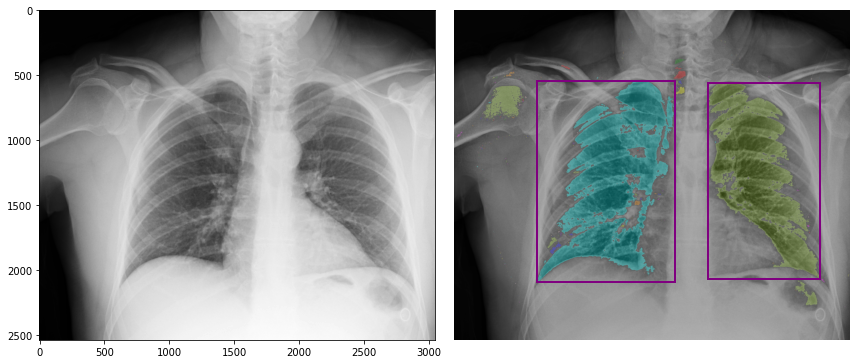

In [5]:
# Use the studyID to get an image
image = load_image('00292f8c37bd')
segment(image)

- The results aren't bad. The colored lung pixel areas could be 'grown', or made into convex hull .. something to smooth them out.

#### Let's look at a few more images.

Rectangle(xy=(1629, 482), width=1057, height=1834, angle=0)
Rectangle(xy=(295, 526), width=1059, height=1842, angle=0)


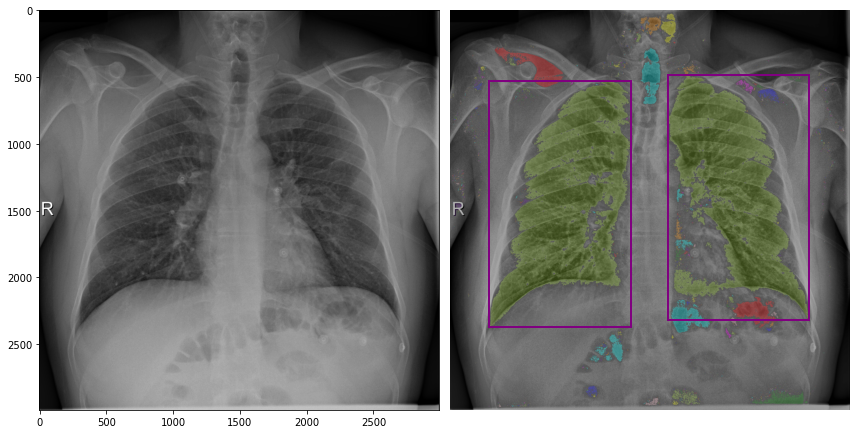

In [6]:
image = load_image('013d698aeecb')
segment(image)

Rectangle(xy=(788, 78), width=701, height=1272, angle=0)
Rectangle(xy=(1724, 188), width=579, height=1124, angle=0)


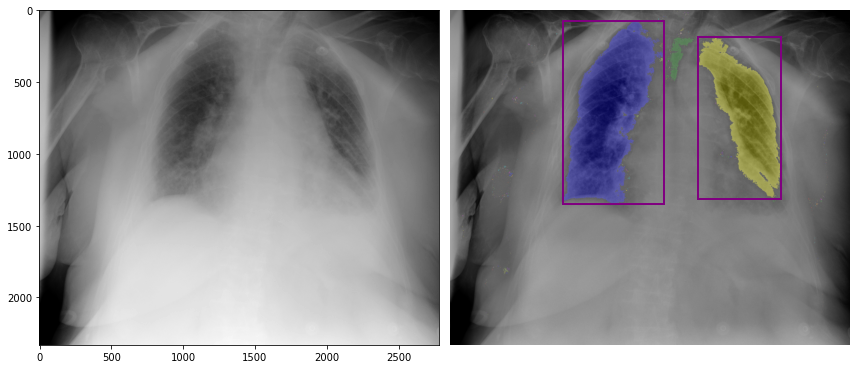

In [7]:
image = load_image('00086460a852')
segment(image)

Rectangle(xy=(67, 326), width=1132, height=2146, angle=0)
Rectangle(xy=(1407, 335), width=1070, height=2046, angle=0)


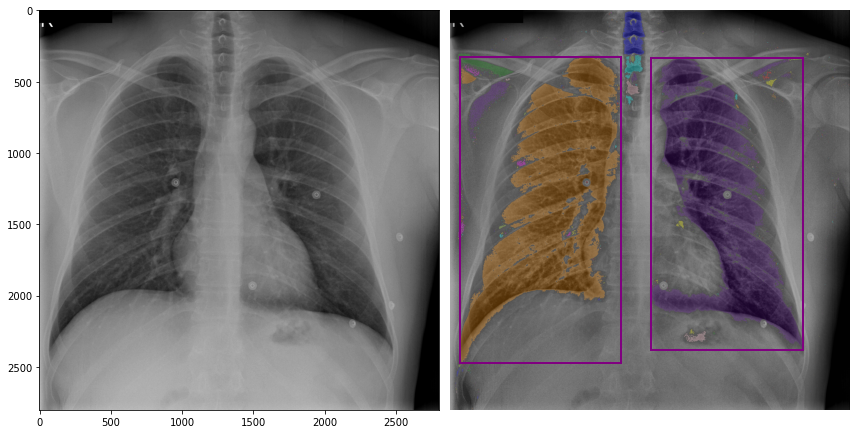

In [8]:
image = load_image('00c74279c5b7')
segment(image)

Rectangle(xy=(139, 568), width=1247, height=1935, angle=0)
Rectangle(xy=(1613, 582), width=1103, height=2124, angle=0)


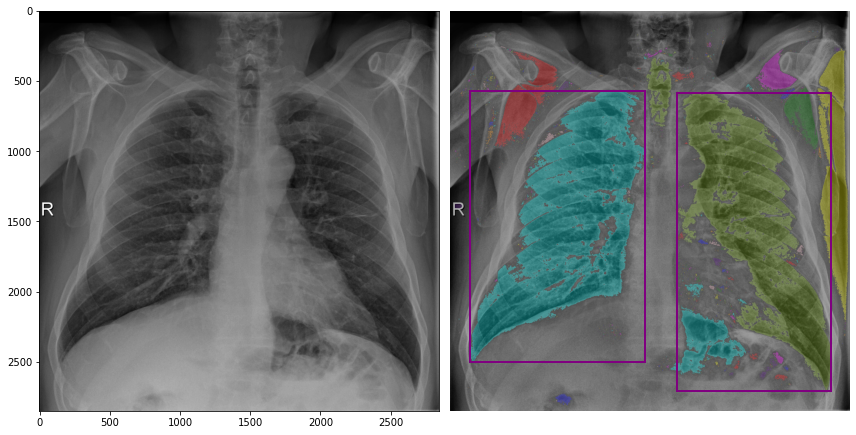

In [9]:
image = load_image('015a2029ad0c')
segment(image)

### Conclusion

- Bounding box data and segment maps can be extracted and used for further processing/modeling.
- Using thresholding to segment images might actually be useful in finding lung tissue in chest radiographs due to the relatively contrasty periphery.
- Adjustments to the input image's contrast might result in even better segmentation.
- This is reasonably accurate on images that aren't diagnostically crappy.